# Time Series Analysis

**Miembros**
- Andrés Montoya 21552
- Fernanda Esquivel 21542
- Francisco Castillo 21562
- Fabián Juárez 21440
- Diego Lemus 21469

**Link al repositorio**

El repositorio puede ser visualizado [acá](https://github.com/FerEsq/DL-TimeSeries-Analysis)

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

# Task 1

In [6]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])

## Limpieza de datos

In [7]:
# Check for missing values
print('Train missing values:', train.isnull().sum().sum())

Train missing values: 0


## Exploración de datos

In [8]:
# Show date range from train and test
print('Train date range:', train['date'].min().date(), 'to', train['date'].max().date())
print('Test date range:', test['date'].min().date(), 'to', test['date'].max().date())

Train date range: 2013-01-01 to 2017-12-31
Test date range: 2018-01-01 to 2018-03-31


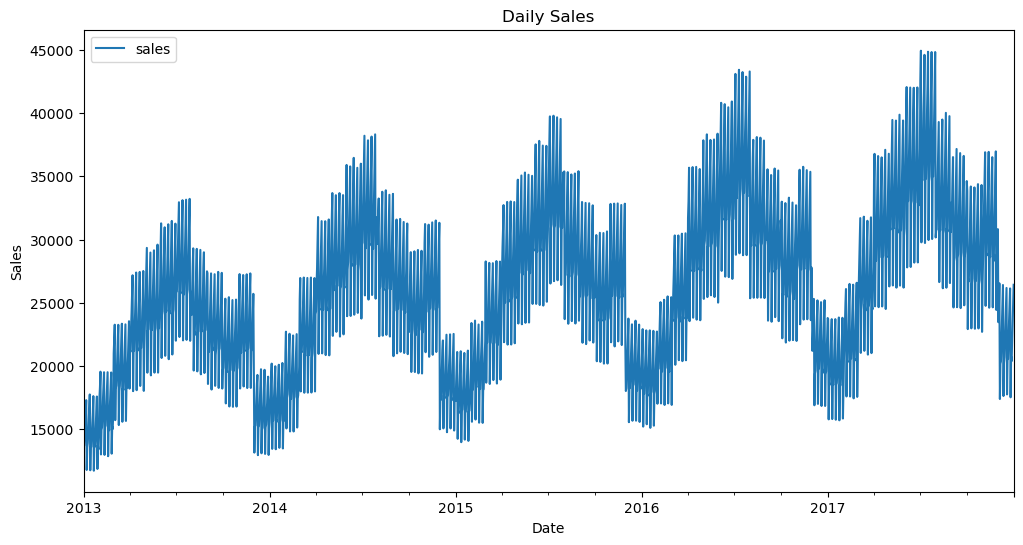

In [9]:
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_sales.plot(x='date', y='sales', figsize=(12, 6))
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

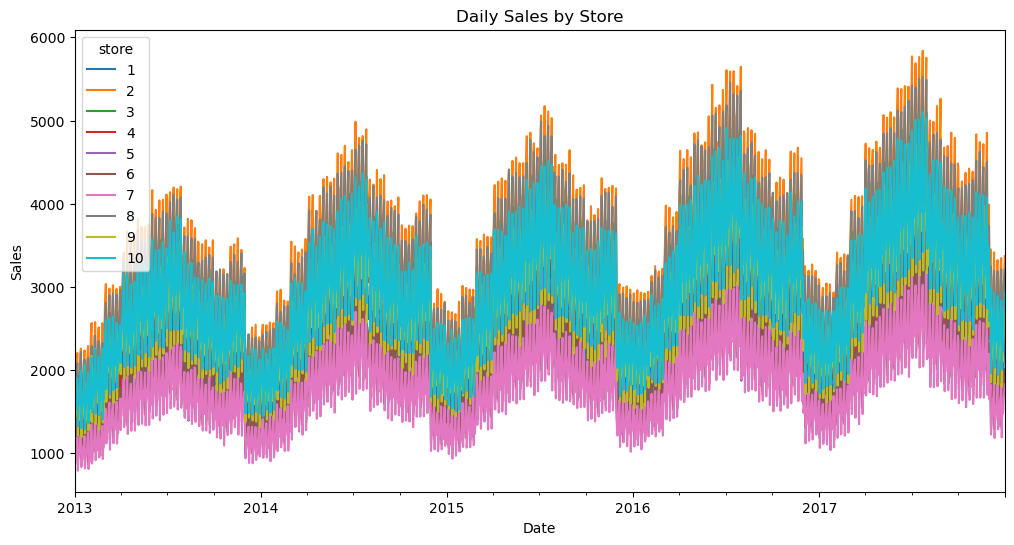

In [10]:
store_daily_sales = train.groupby(['store', 'date'])['sales'].sum().reset_index()
store_daily_sales = store_daily_sales.pivot(index='date', columns='store', values='sales')
store_daily_sales.plot(figsize=(12, 6))
plt.title('Daily Sales by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

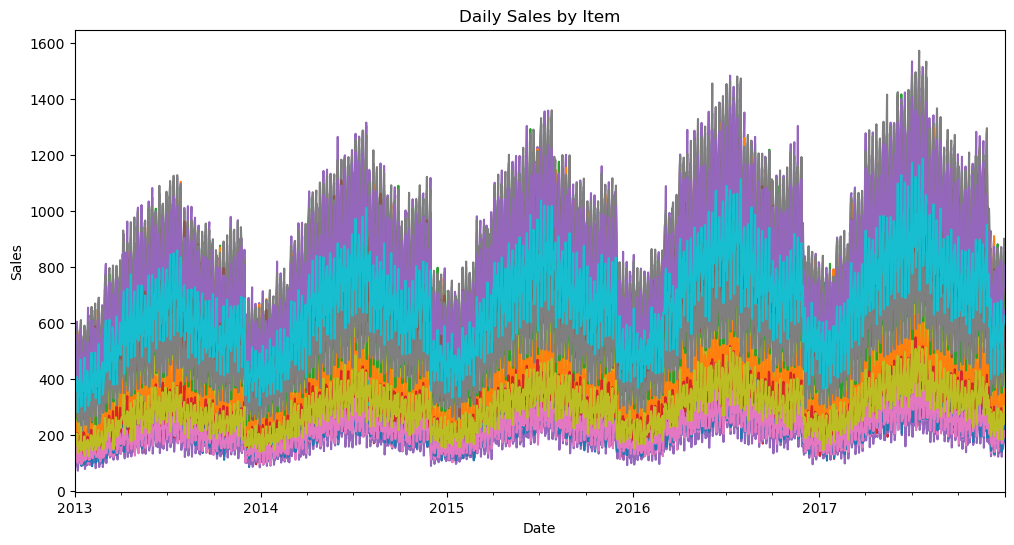

In [11]:
item_daily_sales = train.groupby(['item', 'date'])['sales'].sum().reset_index()
item_daily_sales = item_daily_sales.pivot(index='date', columns='item', values='sales')
item_daily_sales.plot(figsize=(12, 6))
plt.title('Daily Sales by Item')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.gca().get_legend().remove()  # Si no, no se lee =(
plt.show()

Podemos observar que los datos parecieran tener una tendencia estacional, con patrones recurrentes a lo largo del tiempo. Cada año se repiten los mismos picos y valles en las ventas, lo cual sugiere que la estacionalidad es un factor importante a considerar en el análisis y pronóstico de las series temporales. Para el entrenamiento, se considerará solamente la información de **2017** en adelante.

In [12]:
train = train[train['date'].dt.year >= 2017]

## Preprocesamiento de datos

In [13]:
def create_sequences(data, window_size, lag,):
    columns, names = [], []

    # Input sequence (t-window, ..., t-1)
    for i in range(window_size, 0, -1):
        columns.append(data.shift(i))
        names += [f'{col}(t-{i})' for col in data.columns]

    # Current timestep (t=0)
    columns.append(data)
    names += [f'{col}(t)' for col in data.columns]

    # Target timestep (t+lag)
    columns.append(data.shift(-lag))
    names += [f'{col}(t+{lag})' for col in data.columns]

    # Concatenate columns
    df = pd.concat(columns, axis=1)
    df.columns = names
    
    return df.dropna()

In [14]:
train.drop(['date'], axis=1, inplace=True)

In [15]:
window_size = 29  # 30 days
lag = 90  # 90 days

sequences = create_sequences(train, window_size, lag)
sequences.head()

,store(t-29),item(t-29),sales(t-29),store(t-28),item(t-28),sales(t-28),store(t-27),item(t-27),sales(t-27),store(t-26),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+90),item(t+90),sales(t+90)
1490,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9,1.0,1.0,33.0
1491,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17,1.0,1.0,15.0
1492,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15,1.0,1.0,21.0
1493,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17,1.0,1.0,29.0
1494,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24,1.0,1.0,19.0


In [16]:
last_item = f'item(t-{window_size})'
last_store = f'store(t-{window_size})'

sequences = sequences[(sequences['item(t)'] == sequences[last_item])]
sequences = sequences[(sequences['store(t)'] == sequences[last_store])]

In [17]:
columns_to_drop = [f'{col}(t+{lag})' for col in ['store', 'item']]
columns_to_drop += [f'{col}(t)' for col in ['store', 'item']]
for i in range(window_size, 0, -1):
    columns_to_drop += [f'{col}(t-{i})' for col in ['store', 'item']]
columns_to_drop[:5]

['store(t+90)', 'item(t+90)', 'store(t)', 'item(t)', 'store(t-29)']

In [18]:
sequences.drop(columns=columns_to_drop, axis=1, inplace=True)
sequences.head()

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
1490,19.0,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,...,21.0,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9,33.0
1491,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,...,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17,15.0
1492,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,...,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15,21.0
1493,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,...,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17,29.0
1494,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,16.0,...,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,24,19.0


## División de datos

In [19]:
labels_col = f'sales(t+{lag})'
labels = sequences[labels_col]
features = sequences.drop(columns=[labels_col])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, labels.values, test_size=0.3, random_state=2024)

In [17]:
print(f"Train shape: {X_train.shape}\nTest shape: {X_test.shape}")

Train shape: (117537, 30)
Test shape: (50373, 30)


## Modelado

### LSTM

In [18]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(
        50,
        activation='relu',
    ),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,453 (40.83 KB)

 Trainable params: 10,453 (40.83 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
lstm_history = model.fit(
    X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1)),
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1793.2438 - val_loss: 780.9932
Epoch 2/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 1243.9097 - val_loss: 655.2859
Epoch 3/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1151.0604 - val_loss: 539.9863
Epoch 4/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 1064.0933 - val_loss: 507.2705
Epoch 5/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 1030.9220 - val_loss: 521.0437
Epoch 6/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 957.1110 - val_loss: 518.8864
Epoch 7/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 891.1689 - val_loss: 543.5350
Epoch 8/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 825.1004 - val_loss: 448.9550
Epoch 9/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 778.5637 - val_loss: 500.0683
Epoch 10/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 760.8840 - val_loss: 440.4447
Epoch 11/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 

: 

In [20]:
# Save model
model.save('models/model_LSTM.keras')

In [21]:
#load model
model = tf.keras.models.load_model('models/model_LSTM.keras', custom_objects={'mse': MeanSquaredError()})

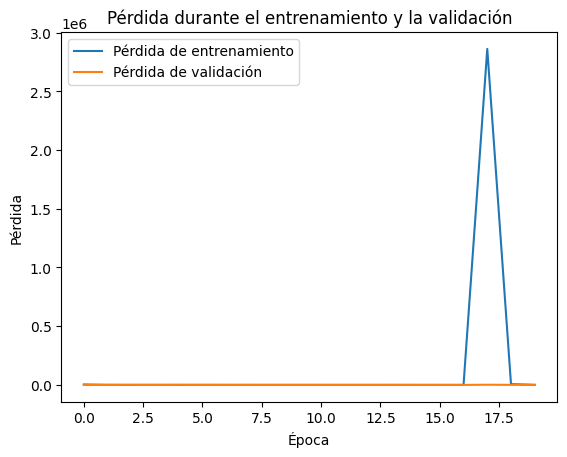

In [22]:
plt.plot(lstm_history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(lstm_history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [28]:
predictions_lstm = model.predict(X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1)))

1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [29]:
mae = mean_absolute_error(y_test, predictions_lstm)
mse = mean_squared_error(y_test, predictions_lstm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions_lstm)

In [30]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 21.760089522733526
MSE: 919.3434392473578
RMSE: 30.320676761038133
R²: 0.08357370623862492


### GRU

In [24]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model_gru.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model_gru.summary()

c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\Dl\DL-TimeSeries-Analysis\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 90, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,817 (89.13 KB)

 Trainable params: 22,817 (89.13 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model_gru.fit(train_sequences, train_targets, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 130s 100ms/step - loss: 23082638.0000 - val_loss: 16407990.0000
Epoch 2/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 153s 123ms/step - loss: 13511784.0000 - val_loss: 5271527.5000
Epoch 3/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 145s 117ms/step - loss: 4211038.0000 - val_loss: 684327.7500
Epoch 4/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - loss: 1587042.1250 - val_loss: 177034.4219
Epoch 5/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - loss: 1466516.6250 - val_loss: 159704.0469
Epoch 6/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - loss: 1471392.7500 - val_loss: 158733.3281
Epoch 7/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - loss: 1455134.1250 - val_loss: 156360.0469
Epoch 8/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 134s 108ms/step - loss: 1464142.0000 - val_loss: 158338.5312
Epoch 9/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - loss: 1443051.6250 - val_loss: 145968.2188
Epoch 10/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 135s 109ms/step - loss: 1

In [26]:
#save model
model_gru.save('models/model_GRU.h5')

In [27]:
#load model
model_gru = tf.keras.models.load_model('models/model_GRU.h5', custom_objects={'mse': MeanSquaredError()})

In [28]:
validation_sequences, validation_targets = create_sequences(validation_set, window_size, forecast_horizon)
validation_sequences = validation_sequences.reshape((validation_sequences.shape[0], validation_sequences.shape[1], 1))

val_loss = model_gru.evaluate(validation_sequences, validation_targets)
print(f'Pérdida en el conjunto de validación: {val_loss}')

4275/4275 ━━━━━━━━━━━━━━━━━━━━ 114s 26ms/step - loss: 6955387.0000
Pérdida en el conjunto de validación: 5419421.5


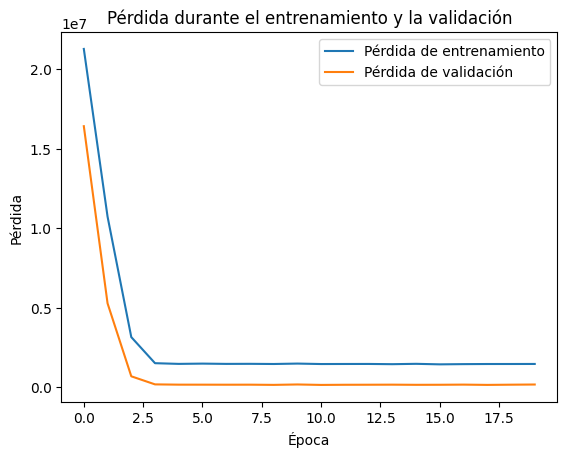

In [29]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [30]:
test_sequences, test_targets = create_sequences(test_set, window_size, forecast_horizon)
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

predictions = model_gru.predict(test_sequences)

4275/4275 ━━━━━━━━━━━━━━━━━━━━ 121s 28ms/step


In [31]:
mae = mean_absolute_error(test_targets, predictions)
print(f"MAE: {mae}")

mse = mean_squared_error(test_targets, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

r2 = r2_score(test_targets, predictions)
print(f"R²: {r2}")

MAE: 1831.97065141262
MSE: 4812324.554903216
RMSE: 2193.701108834842
R²: -0.014141440391540527


## Ajuste de hiperparámetros LSTM

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [19]:
# Modificación de hiperparámetros
units = 100  # Aumentamos el número de unidades en la capa LSTM
dropout_rate = 0.2  # Mantener la tasa de dropout

In [20]:
# Crear el modelo LSTM ajustado
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(
        units,
        activation='relu',
    ),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1)
])

In [21]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

In [22]:
# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,903 (159.78 KB)

 Trainable params: 40,903 (159.78 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Entrenar el modelo
lstm_history = model.fit(
    X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1)),
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 67s 22ms/step - loss: 1477.3850 - val_loss: 516.7491
Epoch 2/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 57s 20ms/step - loss: 1164.5040 - val_loss: 673.1267
Epoch 3/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 1083.8153 - val_loss: 503.4423
Epoch 4/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 71s 24ms/step - loss: 1086.7961 - val_loss: 477.5371
Epoch 5/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 74s 25ms/step - loss: 1014.9746 - val_loss: 554.4000
Epoch 6/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 959.7271 - val_loss: 518.0190
Epoch 7/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - loss: 981.6881 - val_loss: 536.4556
Epoch 8/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 75s 25ms/step - loss: 926.3518 - val_loss: 588.4363
Epoch 9/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 69s 23ms/step - loss: 891.7328 - val_loss: 505.3295
Epoch 10/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - loss: 842.8519 - val_loss: 602.1584
Epoch 11/20
2939/2939 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/st

In [24]:
# Guardar el modelo ajustado
model.save('models/model_LSTM_adjusted.keras')

In [25]:
# Cargar el modelo para predicciones
model = tf.keras.models.load_model('models/model_LSTM_adjusted.keras')

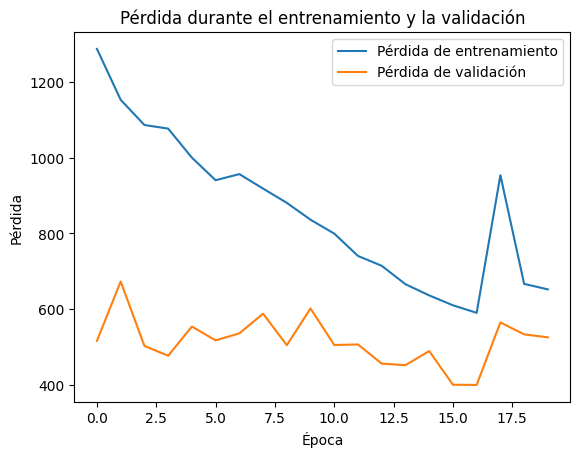

In [26]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(lstm_history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(lstm_history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [27]:
# Realizar predicciones en el conjunto de prueba
predictions_lstm = model.predict(X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1)))

1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step


In [28]:
# Calcular métricas de rendimiento
mae = mean_absolute_error(y_test, predictions_lstm)
mse = mean_squared_error(y_test, predictions_lstm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions_lstm)

In [29]:
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 17.33782062981484
MSE: 532.6996059158164
RMSE: 23.08028608825758
R²: 0.4689906897717824


## Forecasting

In [21]:
model = load_model('models/model_LSTM.keras', custom_objects={'mse': MeanSquaredError()})

In [23]:
# Predicciones sobre los datos de prueba
predictions = model.predict(X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1)))
predictions_3_months = predictions[-90:]

1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


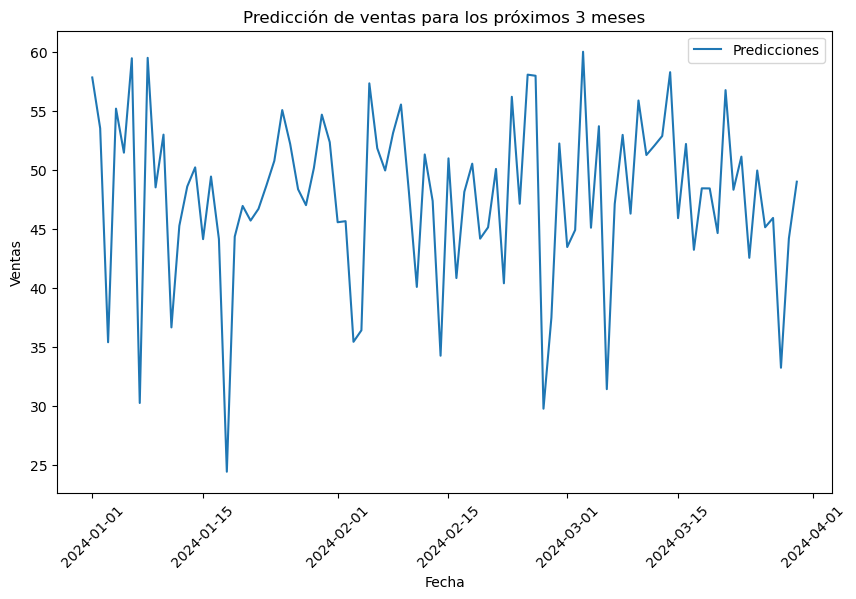

In [24]:
dates = pd.date_range(start='2024-01-01', periods=90, freq='D')

plt.figure(figsize=(10, 6))
plt.plot(dates, predictions_3_months, label='Predicciones')
plt.title('Predicción de ventas para los próximos 3 meses')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Task 2

#### 1. ¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de series temporales?
* El problema del gradiente de fuga ocurre cuando los gradientes que se propagan a través de las capas de una red neuronal recurrente, como una LSTM, se hacen extremadamente pequeños durante la retropropagación. Esto sucede principalmente en secuencias largas, donde los gradientes se diluyen antes de llegar a las capas iniciales, afectando la capacidad del modelo para aprender dependencias a largo plazo. 
* En el contexto de pronóstico de series temporales, este problema reduce la efectividad de las LSTM al dificultar la captación de patrones o relaciones en series de datos que dependen de eventos distantes en el tiempo. Aunque las LSTM están diseñadas para mitigar este problema mediante su arquitectura de puertas, no lo eliminan completamente, y su desempeño puede verse afectado si las secuencias son demasiado largas o si los datos son ruidosos


#### 2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?
* La estacionalidad en series temporales se refiere a patrones recurrentes que se repiten en intervalos regulares. Para abordar este aspecto al usar LSTM, es común aplicar transformaciones previas a los datos, como la diferenciación estacional, que ayuda a eliminar estos patrones recurrentes antes de entrenar el modelo.
* La diferenciación es una técnica que implica restar valores consecutivos de la serie, ayudando a estabilizar la serie y remover tendencias o estacionalidades. Al hacerlo, el modelo LSTM puede concentrarse en predecir patrones más consistentes, sin ser desviado por ciclos repetitivos. Además de la diferenciación, otras técnicas incluyen el uso de características adicionales (lags) o la incorporación de la información estacional directamente como una entrada al modelo. De esta manera, las LSTM son capaces de enfocarse tanto en las fluctuaciones a corto plazo como en las tendencias subyacentes.


#### 3. ¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?
* El "tamaño de ventana" se refiere a la cantidad de datos históricos que se utilizan como entrada para el modelo LSTM para predecir el siguiente valor en la serie temporal. Es una ventana deslizante que define el horizonte temporal que el modelo usa para hacer su predicción.
* Si el tamaño de ventana es demasiado pequeño, el modelo puede no tener suficiente información para capturar patrones a largo plazo, lo que afecta su capacidad para hacer predicciones precisas en series con tendencias prolongadas.
* Por otro lado, un tamaño de ventana demasiado grande puede incluir demasiados datos irrelevantes, lo que lleva a un modelo más complejo que podría sobreajustarse a los patrones de ruido en lugar de generalizar. La elección del tamaño de ventana es crucial porque define el equilibrio entre la capacidad del modelo para detectar patrones a corto y largo plazo, y afecta directamente su desempeño en tareas de pronóstico.


### Referencias
1. Buckley, B. (2023). ¿Cuál es el problema del gradiente de fuga? - Academia EITCA. EITCA Academy. https://es.eitca.org/artificial-intelligence/eitc-ai-gcml-google-cloud-machine-learning/first-steps-in-machine-learning/deep-neural-networks-and-estimators/what-is-the-vanishing-gradient-problem/
2. Rojas-Jimenez, K. (s. f.). Capítulo 8 Análisis de Series de Tiempo | Ciencia de Datos para Ciencias Naturales. https://bookdown.org/keilor_rojas/CienciaDatos/an%C3%A1lisis-de-series-de-tiempo.html
3. Andrés, D., & Andrés, D. (2023). Métodos de pronóstico de Series Temporales - ML Pills. ML Pills - Machine Learning Pills. https://mlpills.dev/series-temporales/pronostico-de-series-temporales/